In [ ]:
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
import tensorflow as tf


from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

#this base model is one branch of the main model

#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_len, fsize):
    
    #the input is a time series of length n and width 1
    input_seq = Input(shape=(input_len, 1))
    
    #choose the number of convolution filters
    nb_filters = 10

    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)

    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

#this is the main model

#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [763, 1526, 3052], fsizes = [8,16,24]):
    
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape=(inputs_lens[0], 1))
    input_medseq = Input(shape=(inputs_lens[1] , 1))
    input_origseq = Input(shape=(inputs_lens[2], 1))

    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    
    #concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    layer = Dense(50, activation='sigmoid')(merged)
    out = Dense(5, activation='softmax')(layer)
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model

def load_data(filename_arff):
    dataset = arff.loadarff(filename_arff)
    data = dataset[0]
    df = pd.DataFrame(data)
    input_data_df = df.iloc[:, 0:3052]
    
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    #perform one-hot encoding on 'team' column 
    labels_df = pd.DataFrame(encoder.fit_transform(df[['target']]).toarray())    
    labels_df.columns = ['Artifact','ExtraHLS','ExtraStole','Murmur','Normal']
    return input_data_df, labels_df

m = main_model()
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

(X_train, y_train) = load_data('AbnormalHeartbeat_TRAIN.arff')
(X_test, y_test) = load_data('AbnormalHeartbeat_TEST.arff')


X_train_downsampled2 = X_train.iloc[:,::2]
X_train_downsampled4 = X_train.iloc[:,::4]

history = m.fit([X_train_downsampled4, X_train_downsampled2, X_train], y_train, validation_split=0.1, epochs=167)

# plot metrics
plt.plot(history.history['accuracy'])
plt.show()

X_test_downsampled2 = X_test.iloc[:,::2]
X_test_downsampled4 = X_test.iloc[:,::4]
score = m.evaluate([X_test_downsampled4, X_test_downsampled2, X_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

df = X_test.T

df.iloc[0:2048,300].plot()


In [ ]:
from scipy.io import arff
import pandas as pd

dataset = arff.loadarff('AbnormalHeartbeat_TEST.arff')
data = dataset[0]
df = pd.DataFrame(data)

df.info()
df.head()

In [ ]:
import arff
import numpy as np

dataset = arff.load(open('AbnormalHeartbeat_TRAIN.arff', 'rt'))
data = np.array(dataset['data'])

input_data_str = data[:, 0:3052]
input_data = input_data_str.astype(np.float32)
labels = data[:,3053]

In [ ]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

dataset = arff.loadarff('AbnormalHeartbeat_TEST.arff')
data = dataset[0]

df = pd.DataFrame(data)

input_data_df = df.iloc[:, 0:3052]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
labels_df = pd.DataFrame(encoder.fit_transform(df[['target']]).toarray())

print("Done")



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

p = np.linspace(0,40,100)
plt.plot(p,np.sin(17*p))
plt.show()

Epoch 1/30
8/8 [==============================] - 6s 527ms/step - loss: 3.0832 - accuracy: 0.2697 - val_loss: 1.5470 - val_accuracy: 0.8852
Epoch 2/30
8/8 [==============================] - 5s 576ms/step - loss: 1.5400 - accuracy: 0.4440 - val_loss: 1.4908 - val_accuracy: 1.0000
Epoch 3/30
8/8 [==============================] - 4s 442ms/step - loss: 1.3425 - accuracy: 0.4813 - val_loss: 1.4976 - val_accuracy: 0.8689
Epoch 4/30
8/8 [==============================] - 3s 404ms/step - loss: 1.1828 - accuracy: 0.5228 - val_loss: 1.4801 - val_accuracy: 0.8033
Epoch 5/30
8/8 [==============================] - 3s 396ms/step - loss: 1.1703 - accuracy: 0.5311 - val_loss: 1.4654 - val_accuracy: 0.7869
Epoch 6/30
8/8 [==============================] - 3s 407ms/step - loss: 1.0710 - accuracy: 0.5311 - val_loss: 1.4560 - val_accuracy: 0.7705
Epoch 7/30
8/8 [==============================] - 3s 401ms/step - loss: 1.0653 - accuracy: 0.5477 - val_loss: 1.4399 - val_accuracy: 0.7541
Epoch 8/30
8/8 [====

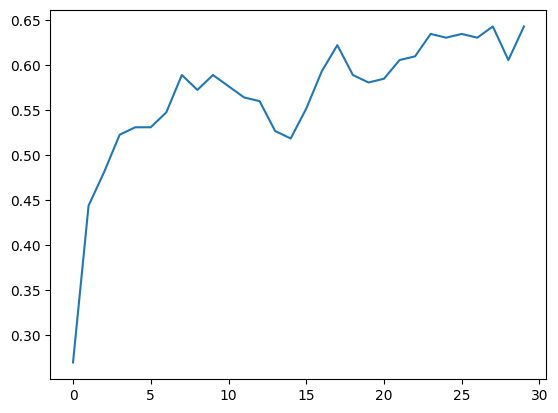

Test loss: 1.2438796758651733
Test accuracy: 0.5164473652839661


In [11]:
from keras.layers import Conv1D, ReLU, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Model

from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
 
# https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
def make_model(input_len, num_classes):
    
    #the input is a time series of length n and width 1
    input_layer = Input(shape=(input_len, 1))
    
    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 =Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalMaxPooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)


def load_data(filename_arff):
    dataset = arff.loadarff(filename_arff)
    data = dataset[0]
    df = pd.DataFrame(data)
    input_data_df = df.iloc[:, 0:3052]
    
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    #perform one-hot encoding on 'team' column 
    labels_df = pd.DataFrame(encoder.fit_transform(df[['target']]).toarray())    
    labels_df.columns = ['Artifact','ExtraHLS','ExtraStole','Murmur','Normal']
    return input_data_df, labels_df


(X_train, y_train) = load_data('AbnormalHeartbeat_TRAIN.arff')
(X_test, y_test) = load_data('AbnormalHeartbeat_TEST.arff')

m = make_model(input_len=3052, num_classes=5)
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = m.fit(X_train, 
                y_train, 
                validation_split=0.2, 
                epochs=30)

# plot metrics
plt.plot(history.history['accuracy'])
plt.show()

score = m.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])